# 4. Dimensional Reduction
Compiled by [Morgan Williams](mailto:morgan.williams@csiro.au) for C3DIS 2018 

Traditional analysis has utilised the similarities in physiochemical properties between geochemical components as a (generally valid) method of dimensional reduction, but excludes data which may otherwise be useful indicators of subtle differences.

Principal component analysis provides a well-tested method of dimensional reduction which - by formulation - retains maximum variance. Visualisation of principal components allows for more of the variance structure to be investigated relative to ternary diagrams. 

The data files used below are synthetic examples from Aitchison (1984).

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
import ternary

sys.path.insert(0, './src')
from compositions import *
from geochem import *
from plotting_tools import *

np.random.seed(1)

In [2]:
fndir = r'data/examples/'
fns = ['boxite.xlsx', 'coxite.xlsx', 'hongite.xlsx', 'kongite.xlsx']
dfs = [pd.read_excel(os.path.join(fndir, f)) for f in fns]
[setattr(df, 'label', fns[ix]) for ix, df in enumerate(dfs)]
B, C, H, K = dfs

## Principal Component Analysis

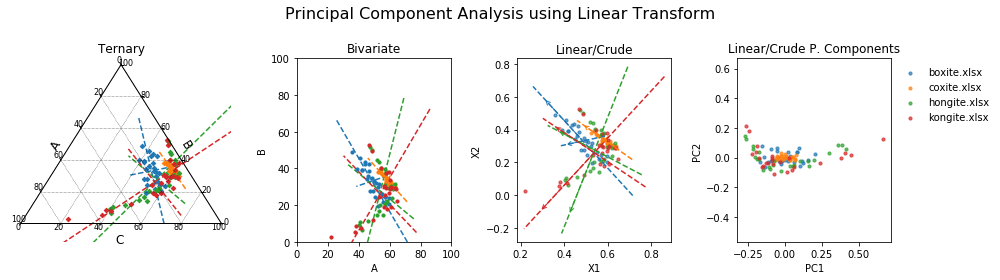

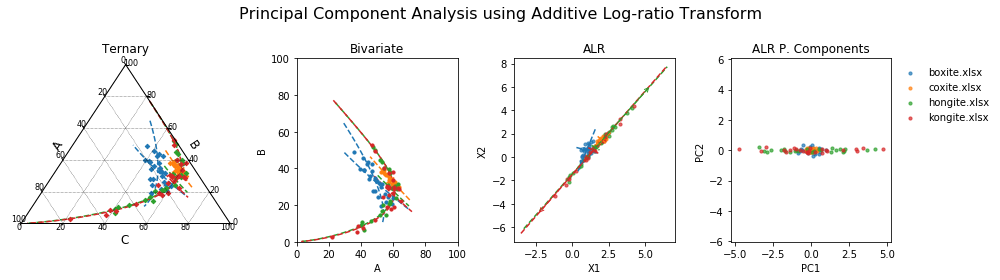

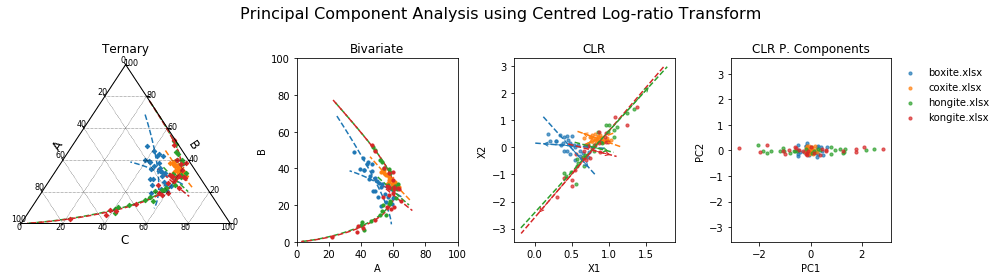

In [90]:
dvars = ['A', 'B', 'C']
markersize=10
TS = [LinearTransform, ALRTransform, CLRTransform]

pca = PCA(n_components=2)

for T, ix in zip(TS, range(4)):
    fig, ax = plt.subplots(1, 4, figsize=(14, 3.5), gridspec_kw = {'width_ratios':[1, 0.7, 0.7, 0.7]})
    f, tax = ternary.figure(ax=ax[0], scale=100)
    ax[0].set_title('Ternary')
    ax[1].set_xlim((0,100))
    ax[1].set_ylim((0,100))
    cleanup_ternary(tax)
    
    for df in [B, C, H, K]:
        data = df.loc[:, dvars].as_matrix()[:, :3]
        data = close(data)       
        
        ax[1].set_xlabel(dvars[0])
        ax[1].set_ylabel(dvars[1])
        ax[1].set_title('Bivariate')
        ax[1].scatter(data[:, 0]*100, data[:, 1]*100, s=markersize)
        t = T()
        d = t.transform(data)
        ax[2].set_xlabel('X1')
        ax[2].set_ylabel('X2')
        scat = ax[2].scatter(d[:, 0], d[:, 1], alpha=0.7, label=df.label, s=markersize)
        ax[2].set_title(t.label)
        pca.fit(d)
        color=mcolors.to_hex(scat.get_facecolor()[0])
        for variance, vector in zip(pca.explained_variance_, pca.components_):
            v = vector[:2] * 3 * np.sqrt(variance)
            draw_vector(pca.mean_[:2],
                        pca.mean_[:2] + v,
                        ax=ax[2],
                        linewidth=1,
                        linestyle='--',
                        color=color)
            line = vector_to_line(pca.mean_, vector, variance, spans=4)
            ax[2].plot(line[:, 0], line[:, 1], color=color, ls='--', lw=1.5)
            
            line = t.inverse_transform(line)
            line = line * 100/line.sum(axis=1)[0]
            ax[1].plot(line[:, 0], line[:, 1], ls='--', lw=1.5, color=color, zorder=-1)
            tax.plot(line, ls='--', lw=1.5, color=color, zorder=-1)
            
        
        # plot principal components
        d_pca = pca.transform(d)
        ax[3].scatter(d_pca[:, 0], d_pca[:, 1], alpha=0.7, label=df.label, color=color, s=markersize)
        
        tax.scatter(data*100, marker='D', s=markersize, color=color)
        tax.left_axis_label("A", fontsize=12)
        tax.right_axis_label("B", fontsize=12)
        tax.bottom_axis_label("C", fontsize=12)
    
    ax[3].axis('equal')
    ax[3].set(xlabel='PC1', ylabel='PC2', title='{} P. Components'.format(t.label))

    ax[-1].legend(frameon=False, loc=2, bbox_to_anchor=(1,1))
    fig.suptitle(f'Principal Component Analysis using {t.longlabel}', y=1.10, fontsize=16)
    plt.tight_layout()